In [1]:
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from scipy import stats
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import precision_score, roc_auc_score, f1_score, recall_score, precision_recall_curve, auc, average_precision_score, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from fancyimpute import IterativeImputer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import GridSearchCV
import xlsxwriter
from random import randint
random_state = 7656
from preprocessing import stds, stats, cv_preprocessing
from load_data import load_data
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
#from tensorflow.keras.layers import Conv2D, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

Using TensorFlow backend.
C:\Users\nogag\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\nogag\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\nogag\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users

average_precision_score = 0.7589138847021911
pr_auc = 0.7572048706464303


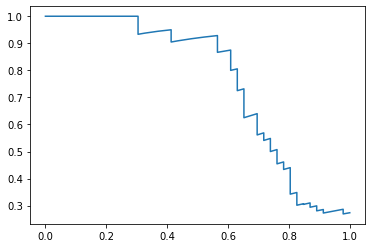

holdout i = , roc_auc = 0.8967169476486248
f
average_precision_score = 0.5221406018567067
pr_auc = 0.5074144710225235


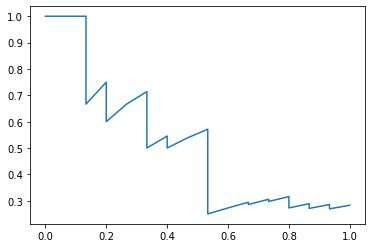

holdout i = , roc_auc = 0.8043290043290043
f
average_precision_score = 0.6201999618840764
pr_auc = 0.616968648627083


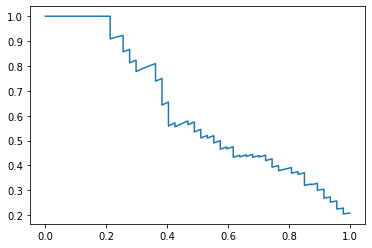

holdout i = , roc_auc = 0.8559270516717326
f
average_precision_score = 0.32820248118762874
pr_auc = 0.28998317519644057


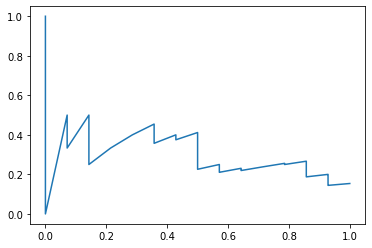

holdout i = , roc_auc = 0.7031539888682745
f
average_precision_score = 0.680614152369927
pr_auc = 0.6776478764300967


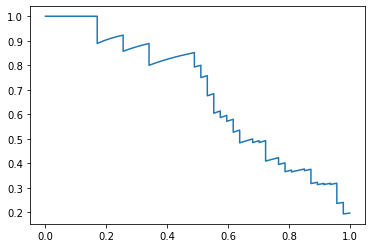

holdout i = , roc_auc = 0.8779852366478507
f
average_precision_score = 0.39137558489031954
pr_auc = 0.35383784928186346


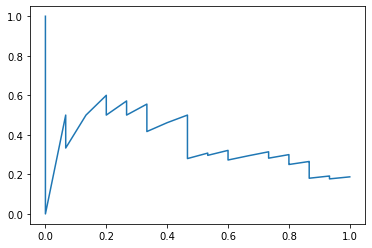

holdout i = , roc_auc = 0.737719298245614
f
average_precision_score = 0.6995033226823302
pr_auc = 0.6970197154919148


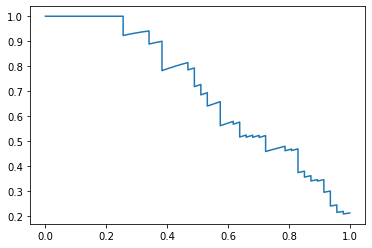

holdout i = , roc_auc = 0.8832826747720365
f
average_precision_score = 0.364063519677809
pr_auc = 0.34447631968251713


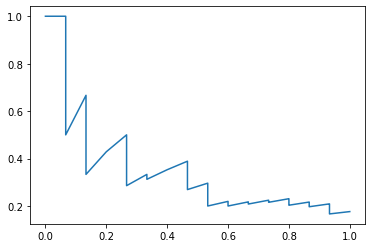

holdout i = , roc_auc = 0.6701754385964913
f
average_precision_score = 0.6106214089519979
pr_auc = 0.6068421084151393


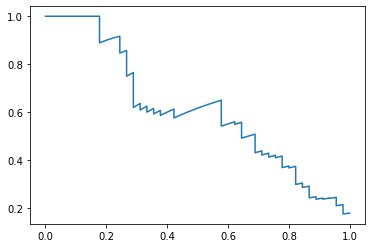

holdout i = , roc_auc = 0.8501124606387764
f
average_precision_score = 0.4505758950439801
pr_auc = 0.4181580220016352


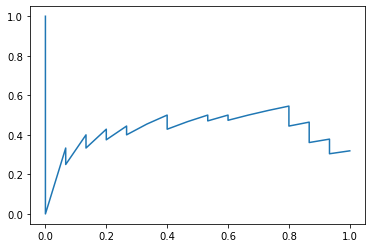

holdout i = , roc_auc = 0.8675438596491228
f


In [4]:
df_preprocessed, features, target_feature = load_data()
# df_preprocessed[phqs2] = 0
# df_preprocessed[phqs2] = df_preprocessed[phqs] + 1
# # df_preprocessed['blop1'] = mode(df_preprocessed[phqs2+pcls], axis=1)[0] > 1
# df_preprocessed['blop2'] = mode(df_preprocessed[pcls], axis=1)[0]
# df_preprocessed['blop3'] = mode(df_preprocessed[phqs2], axis=1)[0]
# features.extend(['blop1', 'blop2'])
df_preprocessed = df_preprocessed.dropna(subset = ['q6.1_INTRU_target', 'q6.2_DREAM_target',
 'q6.3_FLASH_target', 'q6.4_UPSET_target', 'q6.5_PHYS_target'], how='any')
#features2 = [i for i in features if i not in phqs+pcls]


for j in range(1):
    X, X_out, Y, y_out = train_test_split(df_preprocessed[features + ["target_intrusion", "PCL3"]], df_preprocessed['target_binary_tred'],\
                                          test_size=0.15,\
                                          stratify=df_preprocessed['target_binary_tred'])


    cv = StratifiedKFold(5)

    for train, test in cv.split(X, Y):
        
        x_train, y_train = X.iloc[train], Y.iloc[train]
        x_test, y_test = X.iloc[test], Y.iloc[test]
        y_train2 = (x_train["target_intrusion"] > 8).astype(int)
        y_test2 = (x_test["target_intrusion"] > 8).astype(int)
        
        y_train3 = (x_train["PCL3"] > 17).astype(int)
        y_test3= (x_test["PCL3"] > 17).astype(int)
        
        x_train, x_test = cv_preprocessing(x_train[features], x_test[features])
        x_train['blop3'] = x_train[[i for i in x_train.columns if 'outlier' in i]].sum(axis=1)
        x_test['blop3'] = x_test[[i for i in x_test.columns if 'outlier' in i]].sum(axis=1)
        x_test = x_test [features + ['blop3']]
        x_train = x_train [features + ['blop3']]
        model2 = CatBoostClassifier(verbose=0, class_weights={0:1, 1:4},  l2_leaf_reg=1500)
        x_train, x_eval, y_train, y_eval = train_test_split(x_train, y_train, test_size=0.2)

        eval_pool = Pool(x_eval, y_eval)
        
        #model2.fit(x_train,y_train2, eval_set=eval_pool, early_stopping_rounds=1)
        
        model3 = CatBoostClassifier(verbose=0, class_weights={0:10, 1:1}, l2_leaf_reg=150)
        #model3.fit(x_train,y_train3)
        
    #    rfe = RFE(RandomForestClassifier(), n_features_to_select=30)
        model = CatBoostClassifier(verbose=0, class_weights={0:10, 1:1}, l2_leaf_reg=150)
#         x_train = rfe.fit_transform(x_train,y_train)
#         x_test = rfe.transform(x_test)
        model.fit(x_train,y_train,eval_set=eval_pool, early_stopping_rounds=3)
        
        y_pred = model.predict_proba(x_train)[:,1]# * model3.predict_proba(x_test)[:,1]

        
        precision, recall, _ = precision_recall_curve(y_train.astype(int), y_pred)
        avs = average_precision_score(y_train.astype(int), y_pred)
        print(f"average_precision_score = {avs}")

        auc_score = auc(recall, precision)
        print(f"pr_auc = {auc_score}")
        plt.plot(recall, precision)
        plt.show()
        print(f"holdout i = , roc_auc = {roc_auc_score(y_train.astype(int), y_pred)}")
        print('f')

        y_pred = model.predict_proba(x_test)[:,1]# * model3.predict_proba(x_test)[:,1]
        
        #print(f1_score(y_test.astype(int), y_pred))
        precision, recall, _ = precision_recall_curve(y_test.astype(int), y_pred)
        avs = average_precision_score(y_test.astype(int), y_pred)
        print(f"average_precision_score = {avs}")

        auc_score = auc(recall, precision)
        print(f"pr_auc = {auc_score}")
        plt.plot(recall, precision)
        plt.show()
        print(f"holdout i = , roc_auc = {roc_auc_score(y_test.astype(int), y_pred)}")
        print('f')